**Data Wrangling & Feature Engineering**

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from windrose import WindroseAxes
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [4]:
raw_data = pd.read_csv('data/T1.csv')
raw_data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


**Information about features**

-Date/Time (for 10 minutes intervals)

-LV ActivePower (kW): The power generated by the turbine for that moment

-Wind Speed (m/s): The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)

-TheoreticalPowerCurve (KWh): The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer

-Wind Direction (°): The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
Date/Time                        50530 non-null object
LV ActivePower (kW)              50530 non-null float64
Wind Speed (m/s)                 50530 non-null float64
Theoretical_Power_Curve (KWh)    50530 non-null float64
Wind Direction (°)               50530 non-null float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [6]:
 #convert the date column to datetime object
raw_data['Date/Time'] = pd.to_datetime(raw_data['Date/Time']) 

In [7]:
#set the index to the Date time column
raw_data.set_index('Date/Time',inplace=True) 

In [8]:
raw_data.columns

Index(['LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')

In [9]:
 #change column names
raw_data.columns = ['Power','Wind_speed','Theoretical_power','Wind_direction']

In [10]:
raw_data.describe()

,Power,Wind_speed,Theoretical_power,Wind_direction
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [11]:
print(raw_data.index.min())
print(raw_data.index.max())

2018-01-01 00:00:00
2018-12-31 23:50:00


The turbine has recorded data for the year of 2018

In [12]:
#create a loss column
raw_data['Loss'] = raw_data['Theoretical_power'] - raw_data['Power']
raw_data.head(3)

,Power,Wind_speed,Theoretical_power,Wind_direction,Loss
Date/Time,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,36.281117
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,66.148316
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,84.523429


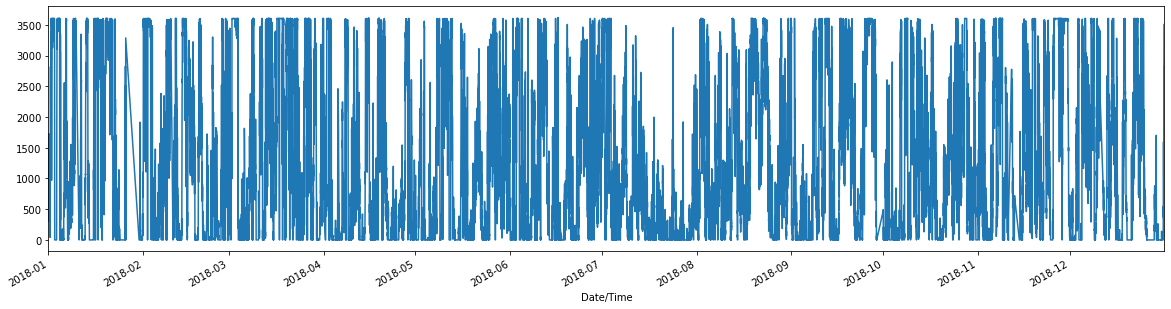

In [13]:
 # due to the random noise, the data will be resampled by every hour

raw_data['Power'].plot(figsize=(20,5))
plt.show()

In [14]:
# create an hourly,daily,weekly,monthly data frame resampled by the mean
hourly = pd.DataFrame()
daily = pd.DataFrame()
weekly = pd.DataFrame()
monthly = pd.DataFrame()

for col in raw_data.columns:
    weekly[col] = raw_data[col].resample('W').mean()

for col in raw_data.columns:
    monthly[col] = raw_data[col].resample('M').mean()

for col in raw_data.columns:
    daily[col] = raw_data[col].resample('D').mean()

for col in raw_data.columns:
    hourly[col] = raw_data[col].resample('H').mean()



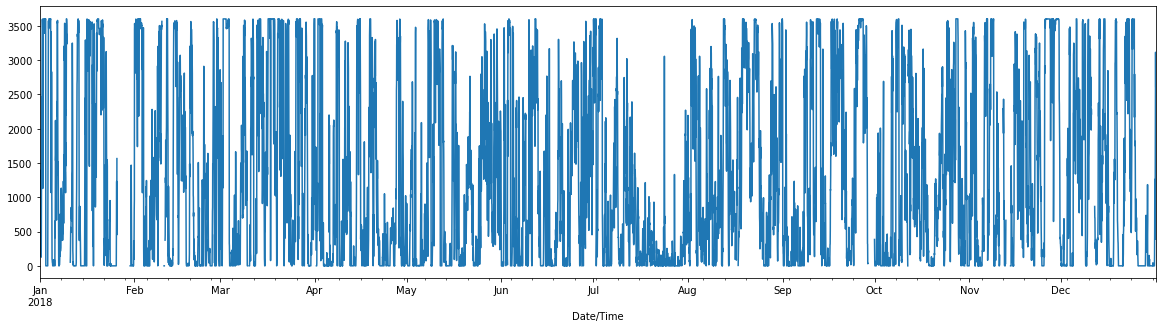

In [15]:
hourly['Power'].plot(figsize=(20,5))
plt.show()

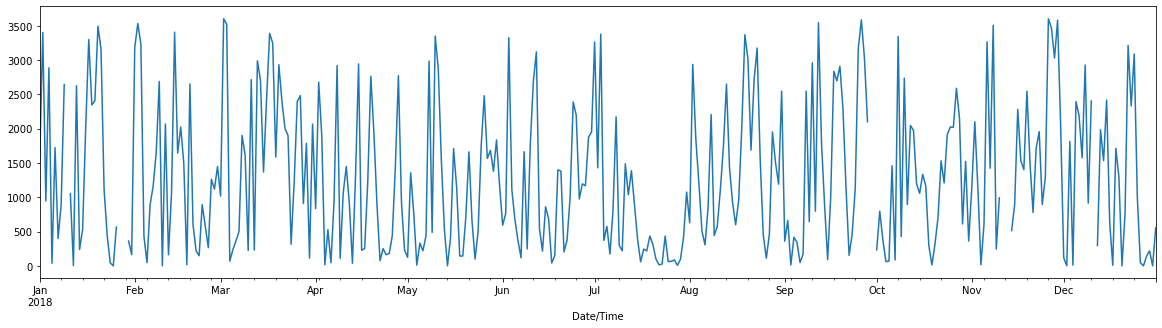

In [16]:
daily['Power'].plot(figsize=(20,5),label='daily')
plt.show()

In [17]:
# create a function for a categorical column 
def direction(x):
    if x > 348.75 or x<11.25: return 'N'
    if x < 33.75: return 'NNE'
    if x < 56.25: return 'NE'
    if x < 78.75: return 'ENE'
    if x < 101.25: return 'E'
    if x < 123.75: return 'ESE'
    if x < 146.25: return 'SE'
    if x < 168.75: return 'SSE'
    if x < 191.25: return 'S'
    if x < 213.75: return 'SSW'
    if x < 236.25: return 'SW'
    if x < 258.75: return 'WSW'
    if x < 281.25: return 'W'
    if x < 303.75: return 'WNW'
    if x < 326.25: return 'NW'
    else: return 'NNW'

In [18]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-01 to 2018-12-31
Freq: D
Data columns (total 5 columns):
Power                356 non-null float64
Wind_speed           356 non-null float64
Theoretical_power    356 non-null float64
Wind_direction       356 non-null float64
Loss                 356 non-null float64
dtypes: float64(5)
memory usage: 17.1 KB


In [19]:
# replace all Nan values with interpolated values for each column
for col in daily.columns:
    daily[col] = daily[col].interpolate()

In [20]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-01 to 2018-12-31
Freq: D
Data columns (total 5 columns):
Power                365 non-null float64
Wind_speed           365 non-null float64
Theoretical_power    365 non-null float64
Wind_direction       365 non-null float64
Loss                 365 non-null float64
dtypes: float64(5)
memory usage: 17.1 KB


In [21]:
#create a categorical column for the direction of wind 
daily['Direction'] = daily['Wind_direction'].apply(direction)

In [22]:
daily.head(3)

,Power,Wind_speed,Theoretical_power,Wind_direction,Loss,Direction
Date/Time,,,,,,
2018-01-01,1535.204483,8.022975,1622.990048,229.735242,87.785565,SW
2018-01-02,3402.762686,14.954779,3443.060749,201.743605,40.298063,SSW
2018-01-03,946.059177,6.628723,1189.168580,143.141018,243.109404,SE


In [23]:
daily['Direction'].unique()

array(['SW', 'SSW', 'SE', 'WSW', 'NE', 'ENE', 'E', 'WNW', 'NNE', 'SSE',
       'W', 'ESE', 'S', 'NW'], dtype=object)

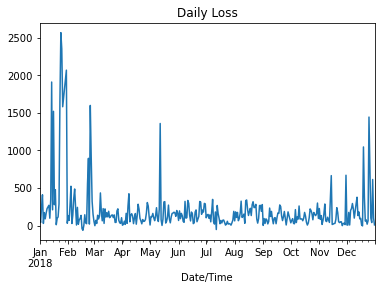

In [24]:
daily['Loss'].plot()
plt.title('Daily Loss')
plt.show()

There are times throughout the year where the turbine has experienced a large amount of Power loss. This is worth investigating further. I suspect this is due to maintenance. 

Between 12-14km/h (**3.3-3.8m/s**) a wind turbine starts to generate electricity.
If the wind speed is higher than 3.3m/s and the power output is zero, we can assume the turbine is under maintenance

In [25]:
print(max(raw_data['Wind_speed']))

25.2060108184814


In [26]:
#check number of data points in raw_data where the wind speed is above 3.3 and power is less than zero
#create a dataframe where times of maintenance are not included
raw_data_nm = raw_data[~((raw_data['Power']<=0) & (raw_data['Wind_speed'] > 3.3))]

In [27]:
raw_data_nm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 47901 entries, 2018-01-01 00:00:00 to 2018-12-31 23:50:00
Data columns (total 5 columns):
Power                47901 non-null float64
Wind_speed           47901 non-null float64
Theoretical_power    47901 non-null float64
Wind_direction       47901 non-null float64
Loss                 47901 non-null float64
dtypes: float64(5)
memory usage: 2.2 MB


In [28]:
raw_data_nm.head(3)

,Power,Wind_speed,Theoretical_power,Wind_direction,Loss
Date/Time,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,36.281117
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,66.148316
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,84.523429


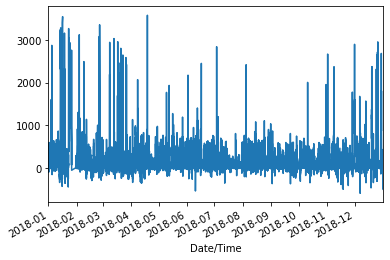

In [29]:
# filtered loss
_ = raw_data_nm['Loss'].plot()


In [30]:
raw_data_nm['Wind_direction'].describe()

count    47901.000000
mean       124.158259
std         93.120761
min          0.000000
25%         50.089802
50%         73.833977
75%        201.691193
max        359.997589
Name: Wind_direction, dtype: float64

In [31]:
#function to create x,y component of wind direction 
def x_y_component(wind_direction, wind_speed):
    """
    Convert degrees to x,y components
    """
    #convert to radians 
    radians = (wind_direction * np.pi)/180
    # give the x, y compenents 
    x = wind_speed * np.cos(radians)
    y = wind_speed * np.sin(radians)
    
    return x,y

In [32]:
raw_data_nm.columns

Index(['Power', 'Wind_speed', 'Theoretical_power', 'Wind_direction', 'Loss'], dtype='object')

In [33]:
# create two extra columns in raw_data_nm for x,y compnenents of wind direction 
raw_data_nm['x_com'], raw_data_nm['y_com'] = x_y_component(raw_data_nm['Wind_direction'],
                                                           raw_data_nm['Wind_speed'])

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [34]:
raw_data_nm.head(3)

,Power,Wind_speed,Theoretical_power,Wind_direction,Loss,x_com,y_com
Date/Time,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,36.281117,-0.922769,-5.230563
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,66.148316,-0.134514,-5.670572
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,84.523429,0.233413,-5.210812


In [35]:
raw_data_nm.describe()

,Power,Wind_speed,Theoretical_power,Wind_direction,Loss,x_com,y_com
count,47901.000000,47901.000000,47901.000000,47901.000000,47901.000000,47901.000000,47901.000000
mean,1379.455360,7.620845,1516.587876,124.158259,137.132516,0.286009,2.094234
std,1310.757275,4.275066,1374.194511,93.120761,274.836874,6.653666,5.255064
min,-2.471405,0.000000,0.000000,0.000000,-598.741011,-24.067548,-16.157409
25%,136.001205,4.272018,175.239701,50.089802,0.000000,-2.673078,-1.858361
50%,946.894287,7.183744,1100.895271,73.833977,61.264984,1.918783,2.325775
75%,2581.499023,10.410110,3021.837387,201.691193,178.177206,4.751993,5.959473
max,3618.732910,25.206011,3600.000000,359.997589,3581.179300,17.494084,17.232180


In [36]:
#resample from no maintenance dataset for every hour, day, week and month
hourly_nm = pd.DataFrame()
daily_nm = pd.DataFrame()
weekly_nm = pd.DataFrame()
monthly_nm = pd.DataFrame()

columns = ['Power','Wind_speed','Theoretical_power','Wind_direction','Loss','x_com','y_com']

for column in columns:
    hourly_nm[column] = raw_data_nm[column].resample('H').mean()

for column in columns:
    daily_nm[column] = raw_data_nm[column].resample('D').mean()

for column in columns:
    weekly_nm[column] = raw_data_nm[column].resample('W').mean()
    
for column in columns:
    monthly_nm[column] = raw_data_nm[column].resample('M').mean()
    

In [37]:
daily_nm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2018-01-01 to 2018-12-31
Freq: D
Data columns (total 7 columns):
Power                355 non-null float64
Wind_speed           355 non-null float64
Theoretical_power    355 non-null float64
Wind_direction       355 non-null float64
Loss                 355 non-null float64
x_com                355 non-null float64
y_com                355 non-null float64
dtypes: float64(7)
memory usage: 22.8 KB


In [38]:
hourly_nm.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-01-01 00:00:00 to 2018-12-31 23:00:00
Freq: H
Data columns (total 7 columns):
Power                8204 non-null float64
Wind_speed           8204 non-null float64
Theoretical_power    8204 non-null float64
Wind_direction       8204 non-null float64
Loss                 8204 non-null float64
x_com                8204 non-null float64
y_com                8204 non-null float64
dtypes: float64(7)
memory usage: 547.5 KB


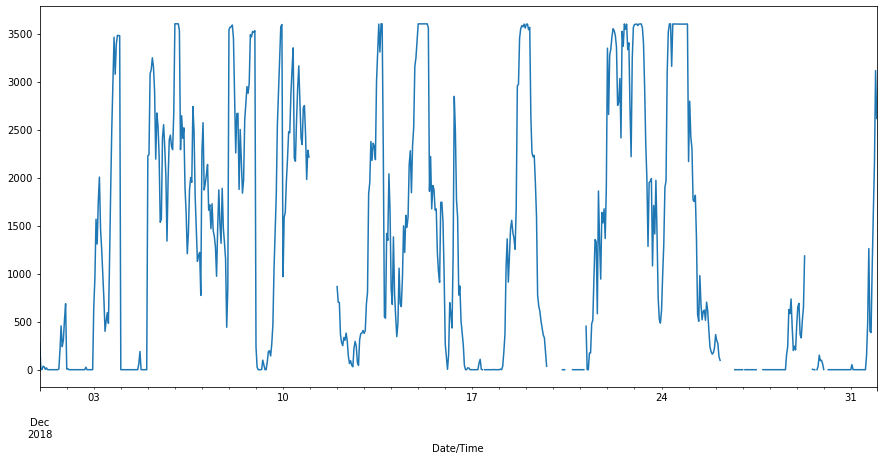

In [39]:
hourly_nm['2018-12']['Power'].plot(figsize=(15,7))
plt.show()

In [40]:
#interpolate values for the hourly no maintenance dataset
for column in hourly_nm.columns:
    hourly_nm[column] = hourly_nm[column].interpolate()

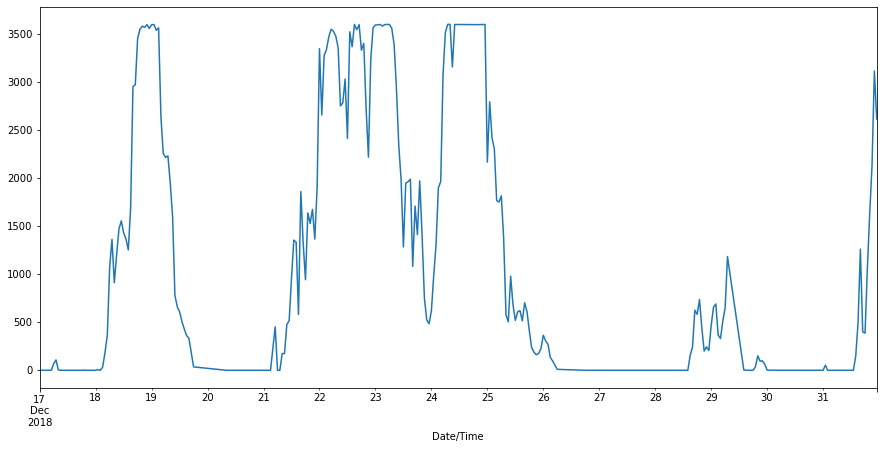

In [41]:
#last two weeks of december
hourly_nm['2018-12-17':'2018-12-31']['Power'].plot(figsize=(15,7))

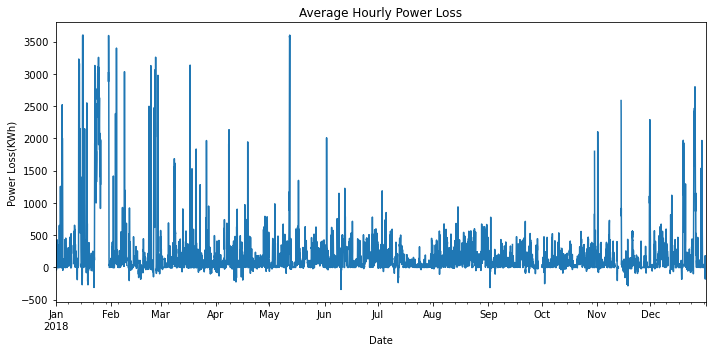

In [42]:
#plot the difference between maintnence and no maintenance
hourly['Loss'].plot(figsize=(10,5))
plt.title('Average Hourly Power Loss')
plt.xlabel('Date')
plt.ylabel('Power Loss(KWh)')
plt.tight_layout()
plt.savefig('figures/hourly_loss.png')
plt.show()

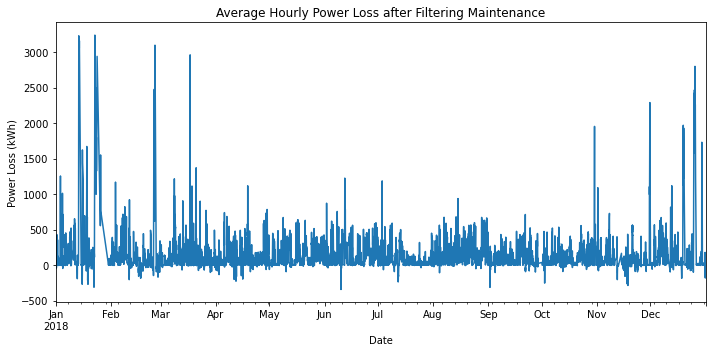

In [43]:
hourly_nm['Loss'].plot(figsize=(10,5))
plt.title('Average Hourly Power Loss after Filtering Maintenance')
plt.ylabel('Power Loss (kWh)')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig('figures/hourly_loss_after_main.png')
plt.show()

From filtering the data when the wind turbine is under maintenance, there are Dates throughout the year when the power loss is minimized, however during January, Febuary and December, there is still extreme power loss. I will investigate this further.

In [44]:
hourly_nm[hourly_nm['Loss']> 500]

,Power,Wind_speed,Theoretical_power,Wind_direction,Loss,x_com,y_com
Date/Time,,,,,,,
2018-01-03 14:00:00,407.834712,5.950712,1041.095307,198.499530,633.260595,-5.527507,-2.119578
2018-01-03 15:00:00,611.752068,7.415358,1556.297757,200.847916,944.545689,-6.834035,-2.815493
2018-01-03 16:00:00,815.669423,8.880004,2071.500206,203.196302,1255.830783,-8.140562,-3.511408
2018-01-04 15:00:00,2882.950562,17.515313,3600.000000,225.292274,717.049438,-12.333057,-12.430648
2018-01-04 18:00:00,2543.731364,11.341170,3377.129777,244.826136,833.398413,-4.750560,-10.154731
...,...,...,...,...,...,...,...
2018-12-29 22:00:00,98.447893,7.473507,1272.937082,25.715890,1174.489190,6.729354,3.225955
2018-12-29 23:00:00,61.213871,8.008990,1539.704053,31.782016,1478.490183,6.808514,4.215678
2018-12-30 00:00:00,1.735934,7.294915,1154.475058,30.964350,1152.739124,6.255299,3.753268


In [45]:
hourly_nm[((hourly_nm['Wind_speed']<6) & (hourly_nm['Power']<100))].head()


,Power,Wind_speed,Theoretical_power,Wind_direction,Loss,x_com,y_com
Date/Time,,,,,,,
2018-01-03 05:00:00,0.0,3.117675,20.873396,45.444939,20.873396,2.187343,2.221582
2018-01-03 06:00:00,0.0,2.618026,0.000000,67.461723,0.000000,1.009629,2.347345
2018-01-03 07:00:00,0.0,1.379726,0.000000,59.512788,0.000000,0.674892,1.106555
2018-01-03 08:00:00,0.0,1.750435,0.000000,135.472839,0.000000,-1.205925,0.425884
2018-01-03 09:00:00,0.0,2.610759,0.000000,194.624153,0.000000,-2.517372,-0.628804


In [46]:
hourly_nm[((hourly_nm['Power']==0) & (hourly_nm['Theoretical_power']>0))].describe()

,Power,Wind_speed,Theoretical_power,Wind_direction,Loss,x_com,y_com
count,342.0,342.000000,342.000000,342.000000,342.000000,342.000000,342.000000
mean,0.0,2.673598,8.516969,152.641287,8.516969,0.653788,0.392846
std,0.0,0.352442,6.365286,100.419425,6.365286,1.687641,1.835662
min,0.0,1.084588,2.677069,3.868128,2.677069,-3.179712,-2.993325
25%,0.0,2.451763,3.721291,62.099439,3.721291,-0.771290,-1.236663
50%,0.0,2.717654,5.902629,129.621741,5.902629,1.016560,0.808879
75%,0.0,2.942203,10.831561,245.501145,10.831561,2.078798,2.079216
max,0.0,3.258679,29.649122,350.963593,29.649122,3.182080,3.200312


It seems the turbine was functioning normally whilst the power output was low. I will keep these data points in my analysis as our model can consider the intermittency  of the wind and whilst the turbine is not as effcient as it should be.  

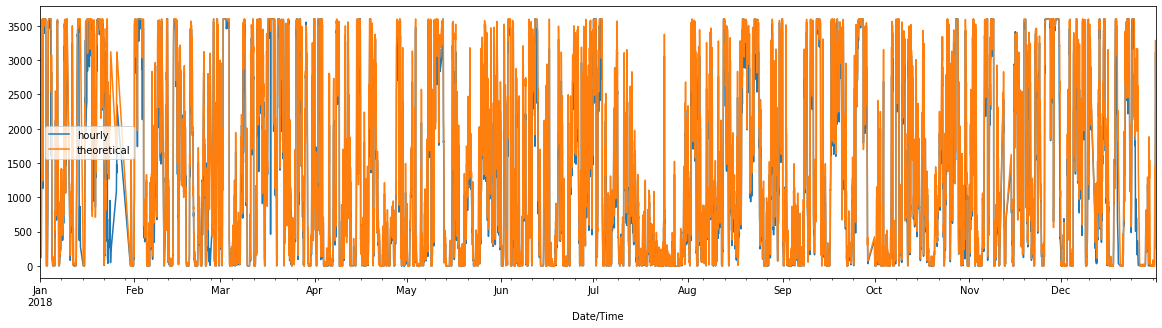

In [47]:
hourly_nm['Power'].plot(figsize=(20,5),label='hourly')
hourly_nm['Theoretical_power'].plot(label='theoretical')
plt.legend()
plt.show()

In [48]:
raw_data['Direction'] = raw_data['Wind_direction'].apply(direction)

In [49]:
raw_data.head(3)

,Power,Wind_speed,Theoretical_power,Wind_direction,Loss,Direction
Date/Time,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,36.281117,W
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,66.148316,W
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,84.523429,W


In [50]:
#add the direction column to the daily,weekly,monthly dataframes no maintenance dataframe
dfs = [hourly_nm, daily_nm, weekly_nm, monthly_nm]

for df in dfs:
    df['Direction'] = df['Wind_direction'].apply(direction)

monthly_nm.head(3)

,Power,Wind_speed,Theoretical_power,Wind_direction,Loss,x_com,y_com,Direction
Date/Time,,,,,,,,
2018-01-31,1850.697339,9.677318,2113.510437,151.037688,262.813098,-2.443793,0.042538,SSE
2018-02-28,1563.237064,8.278136,1698.103519,123.957022,134.866455,-1.588200,2.584775,SE
2018-03-31,1832.531394,9.310503,1932.329374,158.755229,99.797980,-4.802351,-0.804414,SSE


In [51]:
#create a function for the mean wind speed
def mean_wind(x):
    intervals = [*np.arange(0.25,26,0.5)]

    for i in intervals:
            if x < i: 
                x=i-0.25
                return x

In [52]:
raw_data_nm['Mean_speed'] = raw_data_nm['Wind_speed'].apply(mean_wind)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
#add mean wind speed for raw data no maintenance 
raw_data_nm.sample(5)


,Power,Wind_speed,Theoretical_power,Wind_direction,Loss,x_com,y_com,Mean_speed
Date/Time,,,,,,,,
2018-12-28 12:00:00,0.000000,1.780958,0.000000,61.846210,0.000000,0.840327,1.570243,2.0
2018-07-28 09:20:00,0.000000,1.474946,0.000000,19.477489,0.000000,1.390539,0.491801,1.5
2018-09-15 13:40:00,0.000000,1.868064,0.000000,52.670990,0.000000,1.132777,1.485422,2.0
2018-01-11 12:00:00,1259.047974,8.303531,1708.309209,77.031258,449.261235,1.863474,8.091730,8.5
2018-09-08 10:10:00,1400.749023,7.700328,1363.343261,31.015261,-37.405762,6.599413,3.967720,7.5


As the daily power generated will be used for analysis, the autocorrelation and partial autocorrelation function will be used to see if there is a similarity between observations of a function of it's previos time steps.

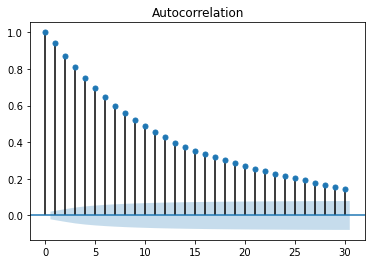

In [54]:
#ACF : ckecks to see if the previos time step has an impact on the next time step
#PCF : see which lag has an impact on the next time step.
plot_acf(hourly_nm['Power'], lags=30)
plt.savefig('figures/acf.png')
plt.show()

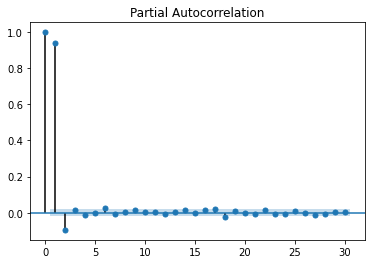

In [55]:
plt.figsize=(20,5)
plot_pacf(hourly_nm['Power'], lags=30)
plt.savefig('figures/pacf.png')
plt.show()

In [56]:
hourly_nm['T_1'] = hourly_nm['Power'].shift(1)

In [57]:
hourly_nm = hourly_nm.dropna()

In [58]:
hourly_nm.head(3)

,Power,Wind_speed,Theoretical_power,Wind_direction,Loss,x_com,y_com,Direction,T_1
Date/Time,,,,,,,,,
2018-01-01 01:00:00,460.537125,5.644205,513.418408,258.945546,52.881284,-1.068567,-5.515860,W,390.480362
2018-01-01 02:00:00,733.655375,6.452037,788.401310,268.397466,54.745935,-0.176225,-6.440522,W,460.537125
2018-01-01 03:00:00,909.362081,6.811455,948.793346,256.014765,39.431265,-1.652917,-6.596464,WSW,733.655375


**Exploratory Data Analysis (EDA)**


In [59]:
#Test to check for stationarity, if mean and variance are roughly similar we can say the data is stationary.
columns = ['Power', 'Wind_speed', 'Theoretical_power', 'Loss','x_com','y_com']
for column in columns:
    feature = hourly_nm[column]
    split = round(len(feature)/2)
    X_1,X_2 = feature[:split], feature[split:]
    mean_1,mean_2 = X_1.mean(), X_2.mean()
    var_1,var_2 = X_1.var(), X_2.var()
    print('For {}'.format(column))
    print('mean1=%f, mean2=%f' % (mean_1, mean_2))
    print('variance1=%f, variance2=%f' % (var_1, var_2))
    print('')

For Power
mean1=1367.149891, mean2=1269.121349
variance1=1673134.481111, variance2=1559169.553640

For Wind_speed
mean1=7.689411, mean2=7.236624
variance1=19.344318, variance2=15.198110

For Theoretical_power
mean1=1551.553324, mean2=1403.031542
variance1=1850154.470182, variance2=1703647.960809

For Loss
mean1=184.403433, mean2=133.910193
variance1=141388.085660, variance2=57103.678486

For x_com
mean1=-0.423583, mean2=1.274358
variance1=46.681277, variance2=35.187456

For y_com
mean1=1.955882, mean2=2.309582
variance1=27.058030, variance2=24.877719



**Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure. 
\
\
**Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
\
\
**p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
\
**p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [60]:
# Second test to check stationarity in data using adfuller test
from statsmodels.tsa.stattools import adfuller

adfull = {}

for column in columns:
    X = hourly_nm[column].values
    result = adfuller(X)
    adfull[column] = [result[1]]

    print('P-value for {}: {}'.format(column,result[1]))

P-value for Power: 3.1768843000927696e-29
P-value for Wind_speed: 4.8283183939692944e-24
P-value for Theoretical_power: 1.9339076618978444e-29
P-value for Loss: 1.0837016547840162e-27
P-value for x_com: 2.5917663452623245e-23
P-value for y_com: 3.2027960461416926e-15


In [61]:
adfull_df = pd.DataFrame.from_dict(adfull)

In [62]:
adfull_df

,Power,Wind_speed,Theoretical_power,Loss,x_com,y_com
0,3.176884e-29,4.828318e-24,1.933908e-29,1.083702e-27,2.591766e-23,3.202796e-15


We can conclude that all the features do not follow a random walk and are stationary. 

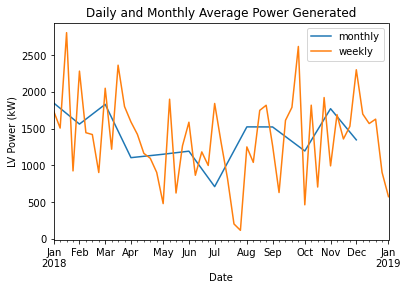

In [63]:
#daily['Power'].plot(figsize=(20,5),label='daily')
monthly_nm['Power'].plot(label='monthly')
weekly_nm['Power'].plot(label='weekly')
plt.title('Daily and Monthly Average Power Generated')
plt.ylabel('LV Power (kW)')
plt.xlabel('Date')
plt.legend()
plt.show()

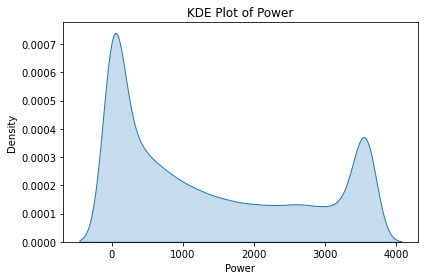

In [64]:
#plot kde of power 
sns.kdeplot(raw_data_nm['Power'],shade=True)
plt.title('KDE Plot of Power')
plt.tight_layout()
plt.savefig('figures/KDE.png')
plt.show()

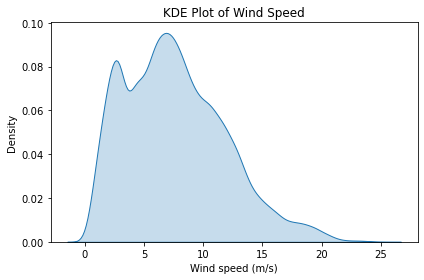

In [65]:
#plot kde of wind speed
sns.kdeplot(raw_data_nm['Wind_speed'],shade=True)
plt.title('KDE Plot of Wind Speed')
plt.xlabel('Wind speed (m/s)')
plt.tight_layout()
plt.savefig('figures/KDE wind_speed.png')
plt.show()

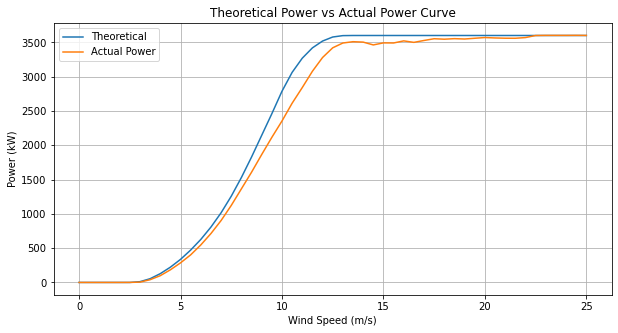

In [66]:
m_s_t_se = raw_data_nm.groupby('Mean_speed')['Theoretical_power'].mean()
m_s_p_se = raw_data_nm.groupby('Mean_speed')['Power'].mean()
plt.figure(figsize=(10,5))
plt.tight_layout()
plt.plot(m_s_t_se,label='Theoretical')
plt.plot(m_s_p_se,label='Actual Power')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Theoretical Power vs Actual Power Curve')
plt.grid(which='major')
plt.legend()
plt.savefig('figures/theo-actual-power-curve.png')
plt.show()

In [67]:
raw_data.columns

Index(['Power', 'Wind_speed', 'Theoretical_power', 'Wind_direction', 'Loss',
       'Direction'],
      dtype='object')

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


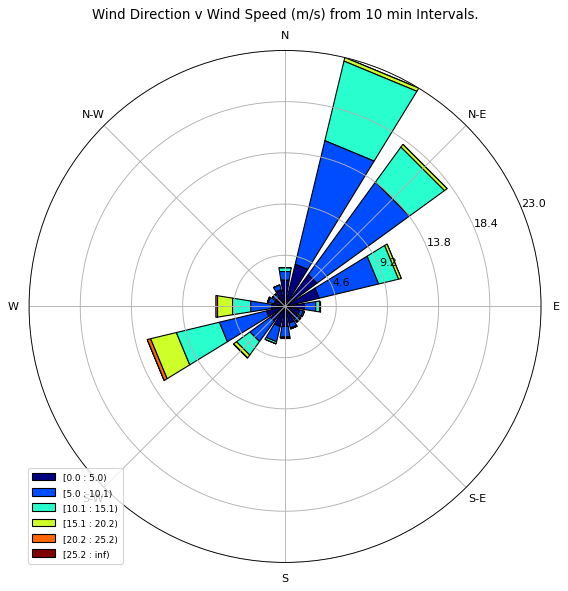

In [68]:
ax = WindroseAxes.from_ax()
ax.bar(raw_data_nm['Wind_direction'], raw_data_nm['Wind_speed'], normed=True, opening=0.8, edgecolor='black')
ax.set_theta_direction('clockwise')
ax.set_theta_zero_location('N')
ax.set_xticklabels(['N', 'N-E', 'E', 'S-E', 'S', 'S-W', 'W', 'N-W'])
ax.set_legend()
plt.title('Wind Direction v Wind Speed (m/s) from 10 min Intervals.')
plt.tight_layout()
plt.savefig('figures/windrose.png')
plt.show()

In [69]:
raw_data_nm['Direction'] = raw_data_nm['Wind_direction'].apply(direction)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


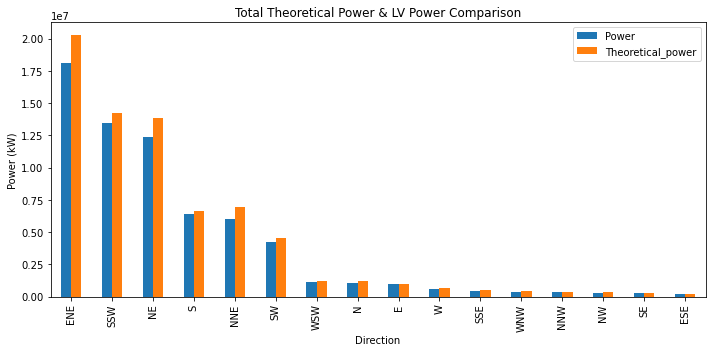

In [70]:
direction_df = raw_data_nm.groupby('Direction')[['Power','Theoretical_power']].sum()
direction_df = direction_df.sort_values(by=['Power'],ascending=False)
direction_df.plot(kind='bar',figsize=(10,5))
plt.title('Total Theoretical Power & LV Power Comparison')
plt.ylabel('Power (kW)')
plt.tight_layout()
plt.savefig('figures/theo_vs_lv_power.png')
plt.show()


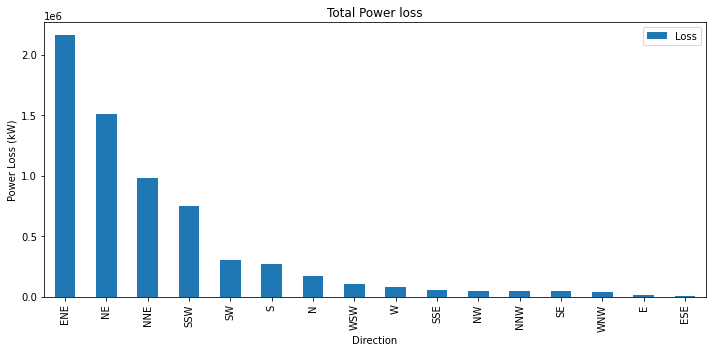

In [71]:
# summary df of grouped daily direction 
dir_loss = raw_data_nm.groupby('Direction')[['Loss']].sum()
dir_loss = dir_loss.sort_values(by=['Loss'],ascending=False)
dir_loss.plot(kind='bar', figsize=(10,5))
plt.title('Total Power loss')
plt.ylabel('Power Loss (kW)')
plt.tight_layout()
plt.savefig('figures/power_loss.png')
plt.show()

Consider the greatest power loss were in ENE, NE, NNE and SSW. I will investigate this further.




In [72]:
raw_data_nm.head(3)

,Power,Wind_speed,Theoretical_power,Wind_direction,Loss,x_com,y_com,Mean_speed,Direction
Date/Time,,,,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,36.281117,-0.922769,-5.230563,5.5,W
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,66.148316,-0.134514,-5.670572,5.5,W
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,84.523429,0.233413,-5.210812,5.0,W


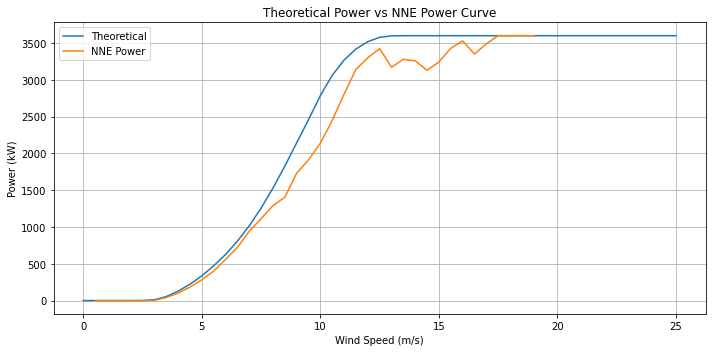

In [73]:
NNE = raw_data_nm[raw_data_nm['Direction']=='NNE']
m_s_p_nne = NNE.groupby('Mean_speed')['Power'].mean()
plt.figure(figsize=(10,5))
plt.plot(m_s_t_se,label='Theoretical')
plt.plot(m_s_p_nne,label='NNE Power')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Theoretical Power vs NNE Power Curve')
plt.grid(which='major')
plt.legend()
plt.tight_layout()
plt.savefig('figures/NNE_p.png')
plt.show()


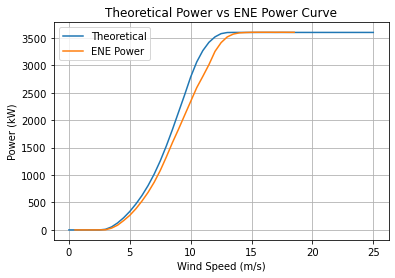

In [74]:
ENE = raw_data_nm[raw_data_nm['Direction']=='ENE']
m_s_p_ene = ENE.groupby('Mean_speed')['Power'].mean()
plt.plot(m_s_t_se,label='Theoretical')
plt.plot(m_s_p_ene,label='ENE Power')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Theoretical Power vs ENE Power Curve')
plt.grid(which='major')
plt.legend()
plt.show()

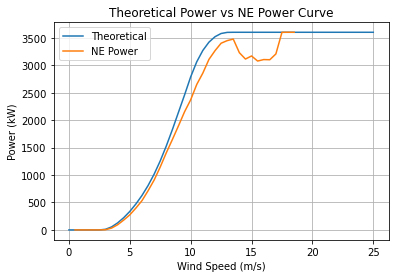

In [75]:
NE = raw_data_nm[raw_data_nm['Direction']=='NE']
m_s_p_ne = NE.groupby('Mean_speed')['Power'].mean()
plt.plot(m_s_t_se,label='Theoretical')
plt.plot(m_s_p_ne,label='NE Power')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Theoretical Power vs NE Power Curve')
plt.grid(which='major')
plt.legend()
plt.show()

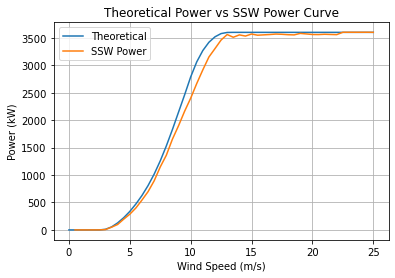

In [76]:
SSW = raw_data_nm[raw_data_nm['Direction']=='SSW']
m_s_p_ssw = SSW.groupby('Mean_speed')['Power'].mean()
plt.plot(m_s_t_se,label='Theoretical')
plt.plot(m_s_p_ssw,label='SSW Power')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Theoretical Power vs SSW Power Curve')
plt.grid(which='major')
plt.legend()
plt.show()

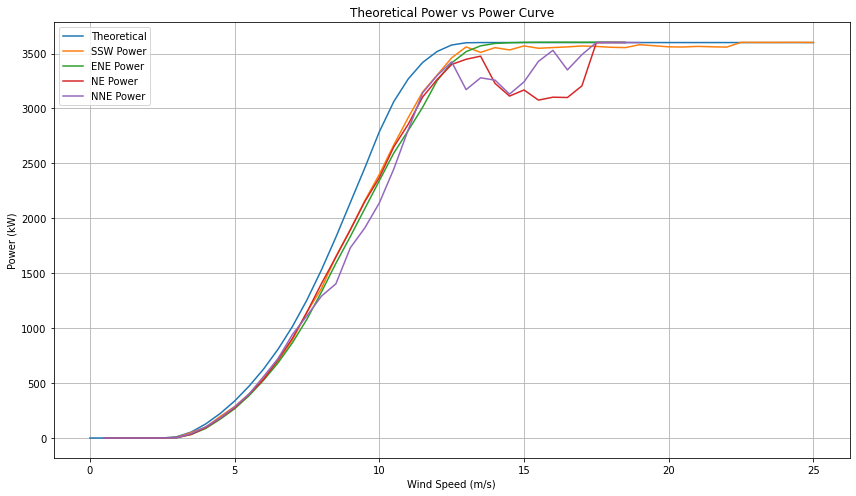

In [77]:
SSW = raw_data_nm[raw_data_nm['Direction']=='SSW']
m_s_p_ssw = SSW.groupby('Mean_speed')['Power'].mean()
plt.figure(figsize=(12,7))
plt.plot(m_s_t_se,label='Theoretical')
plt.plot(m_s_p_ssw,label='SSW Power')
plt.plot(m_s_p_ene,label='ENE Power')
plt.plot(m_s_p_ne,label='NE Power')
plt.plot(m_s_p_nne,label='NNE Power')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power (kW)')
plt.title('Theoretical Power vs Power Curve')
plt.grid(which='major')
plt.legend()
plt.tight_layout()
plt.savefig('figures/power_direction.png')
plt.show()

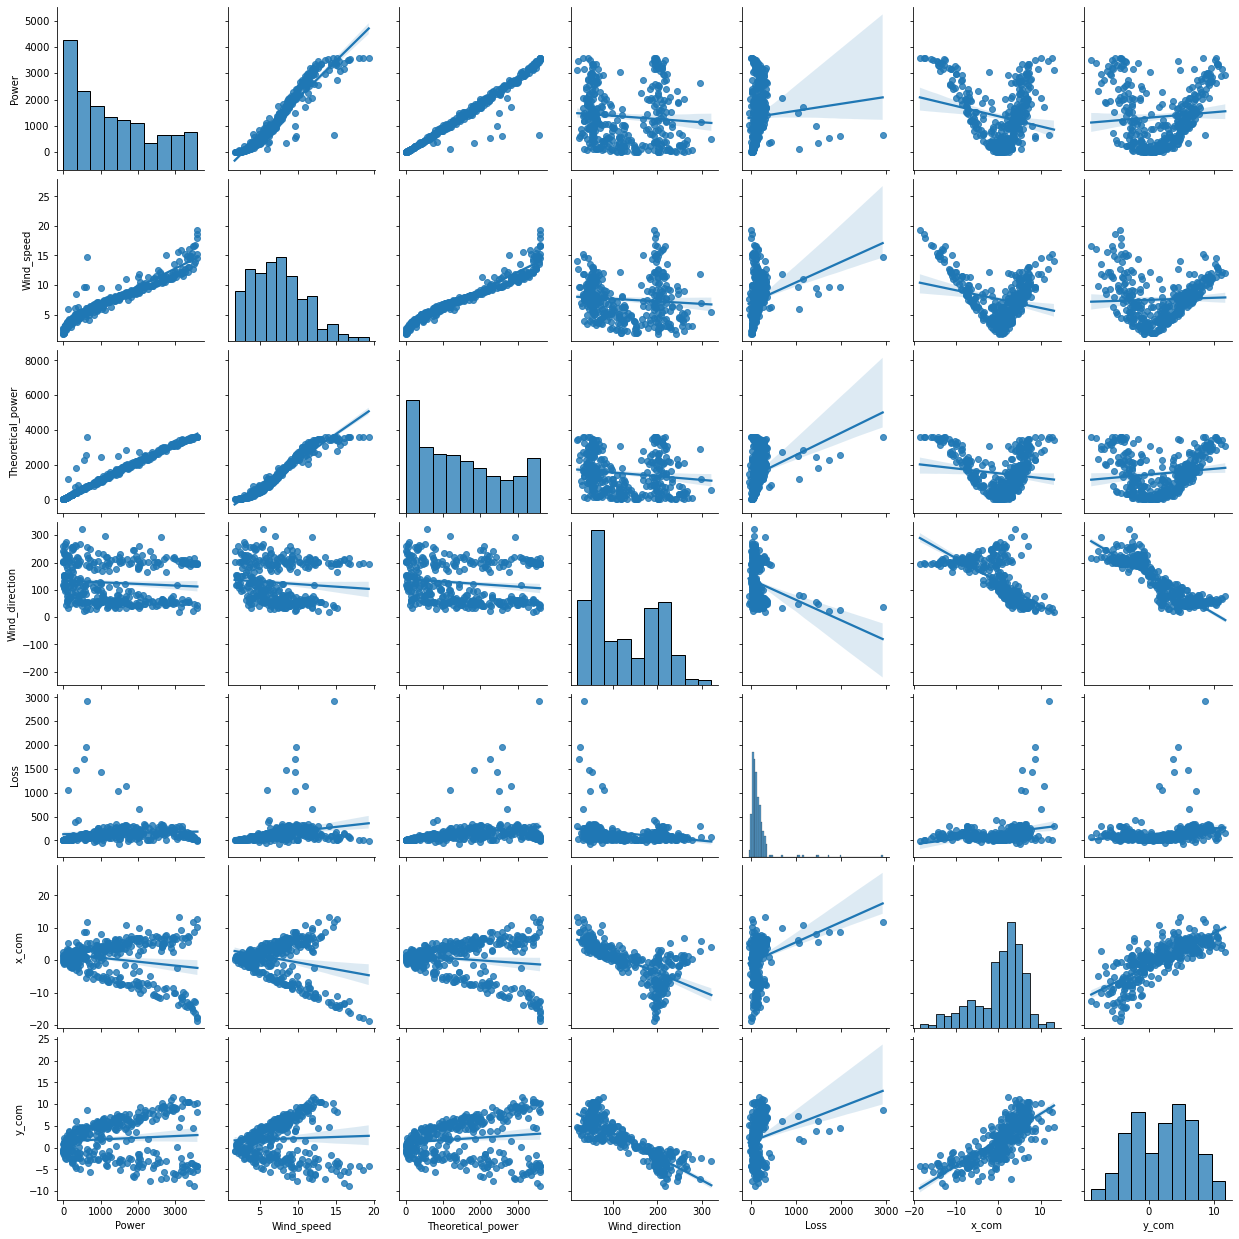

In [78]:
#pairplot
_ = sns.pairplot(daily_nm,kind='reg')

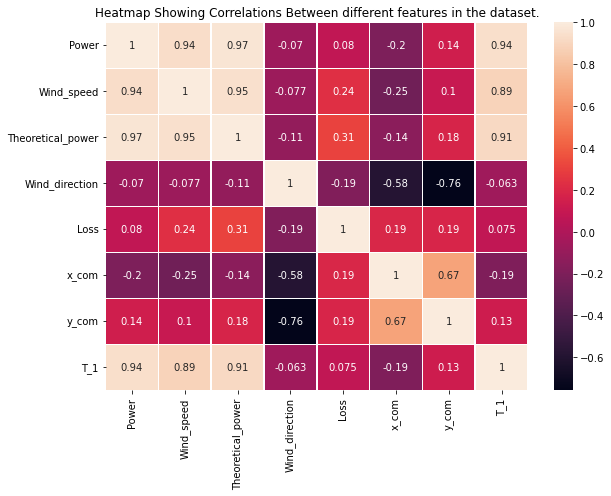

In [79]:
#plot correlation heatmap, if gausian then pearson 
fig, ax = plt.subplots(1, 1,figsize=(9,7))
sns.heatmap(hourly_nm.corr(),annot=True,linewidth=0.5)
plt.title('Heatmap Showing Correlations Between different features in the dataset.')
ax.set_ylabel('')
ax.set_xlabel('')
plt.tight_layout()
plt.savefig('figures/correlation.png')
plt.show()

Next to test the co-inegration between different features of the dataset. 

In [80]:
#test co-integration between features
import statsmodels.api as sm

num_columns = ['Wind_speed', 'Theoretical_power', 'Loss','x_com','y_com']
P = hourly_nm[['Power']]
co_int = {}

for column in num_columns:
    C = hourly_nm[[column]]

    C = sm.add_constant(C)
    result = sm.OLS(P,C).fit()

    #value of the gradient 
    const = result.params[1]
    adf_g = adfuller(hourly_nm[column] - const*hourly_nm['Power'])
    
    co_int[column] = [adf_g[1]]
   
    print('The p-value for the ADF test between {} and Power is: {} '.format(column,adf_g[1]))

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The p-value for the ADF test between Wind_speed and Power is: 3.176826582695178e-29 
The p-value for the ADF test between Theoretical_power and Power is: 7.475041488929635e-28 
The p-value for the ADF test between Loss and Power is: 9.448787719078366e-29 
The p-value for the ADF test between x_com and Power is: 3.1761807119796604e-29 
The p-value for the ADF test between y_com and Power is: 3.1781506250978774e-29 


In [81]:
co_int_df = pd.DataFrame.from_dict(co_int)
co_int_df

,Wind_speed,Theoretical_power,Loss,x_com,y_com
0,3.176827e-29,7.475041e-28,9.448788e-29,3.176181e-29,3.178151e-29


The above test show that all numerical columns are co-integrated with the Power feature of the dataset.

As Wind Direction in degrees is not a suitable feature for RNN's, this will be removed from the dataset.

In [82]:
hourly_nm.drop(labels=['Wind_direction','Direction'],axis=1,inplace=True)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [83]:
hourly_nm.to_csv('data/hourly_nm.csv')